In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import pandas as pd
from tqdm import tqdm
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
#Get all classes 
main_data_dir = '/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/'
all_classes_names = os.listdir(main_data_dir)

In [4]:
image_height, image_width = 128, 128
max_images_per_train_class = 8000
max_images_per_test_class = 4000
 
classes_list = ["shoot_gun", "shoot_ball", "kiss", "smoke"]
 
model_output_size = len(classes_list)
num_classes = 51
frames_per_video = 200
batch_size = 16
epochs = 20

In [5]:
# Function to extract frames from a video
def extract_frames(video_path, skip=9):
    """
    video_path: str
    skip: int
    given a video path, return frames in regular intervals.
    Returns: A sequence of images. For instance, when skip=9, returns every 10th frame of the video
    """
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    while True:
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        frames_list.append(normalized_frame)
    frames_list = [frame for i, frame in enumerate(frames_list) if i % (skip+1) == 0]
    video_reader.release()
    return np.array(frames_list)

def video_frame_generator(video_paths, labels, batch_size=16, every_nth_frame=10, max_frames=20, image_height=128, image_width=128):
    """
    Yields batches of frames and corresponding labels from video files.
    """
    while True:
        X, y = [], []
        for i in range(batch_size):
            video_idx = np.random.randint(0, len(video_paths))
            video_path = video_paths[video_idx]
            label = labels[video_idx]
            
            frames = extract_frames(video_path)
            print(frames.shape)
            # subsample:
            frames = frames[range(0, frames.shape[0], every_nth_frame),:,:,:]
            print(frames.shape)
            if frames is not None:
                # Initialize a padded array of zeros
                padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                
                # Copy the frames into the padded array, truncating if necessary
                num_frames = min(len(frames), max_frames)
                padded_frames[:num_frames] = frames[:num_frames]
                
                X.append(padded_frames)
                y.append(label)  # Append label as-is or pad if needed for sequences
        
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [6]:
def encoded_video_frame_generator(encoder, video_paths, labels, batch_size=16, max_frames=200, image_height=128, image_width=128):
    """
    Yields batches of frames and corresponding labels from video files.
    """
    while True:
        X, y = [], []
        for i in tqdm(range(batch_size)):
            video_idx = np.random.randint(0, len(video_paths))
            video_path = video_paths[video_idx]
            label = labels[video_idx]
            
            frames = extract_frames(video_path)
                
            if frames is not None:
                # Initialize a padded array of zeros
                padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                
                # Copy the frames into the padded array, truncating if necessary
                num_frames = min(len(frames), max_frames)
                padded_frames[:num_frames] = frames[:num_frames]
                encoded_frames = [encoder(np.expand_dims(frame, axis=0)) for frame in padded_frames]
                X.append(np.squeeze(encoded_frames, axis=1))
                y.append(label)  # Append label as-is or pad if needed for sequences
        
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [72]:
def videos_to_encodings(encoder, video_paths, labels, skip_frames=4, max_frames=20, image_height=128, image_width=128):
    """
    Yields encoded videos and corresponding labels from all video paths provided.
    """
    while True:
        X, y = [], []
        with tqdm(total=len(labels)) as pbar:
            for video_path, label in zip(video_paths, labels):
                frames = extract_frames(video_path, skip=skip_frames)    
                if frames is not None:
                    # Initialize a padded array of zeros
                    padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                    # Copy the frames into the padded array, truncating if necessary
                    num_frames = min(len(frames), max_frames)
                    padded_frames[:num_frames] = frames[:num_frames]
    
                    # encode frames with pretrained image encoder
                    encoded_frames = [encoder(np.expand_dims(frame, axis=0)) for frame in padded_frames]
                    X.append(np.squeeze(encoded_frames, axis=1))
                    y.append(label)  # Append label as-is or pad if needed for sequences
                    pbar.update(1)
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [16]:
# Prepare paths and labels for training and testing
video_paths_train = [os.path.join(main_data_dir, cls, f) 
                     for cls in all_classes_names 
                     for f in os.listdir(os.path.join(main_data_dir, cls)) 
                     if "training" in f]

labels_train = [all_classes_names.index(cls) 
                for cls in all_classes_names 
                for f in os.listdir(os.path.join(main_data_dir, cls)) 
                if "training" in f]

video_paths_test = [os.path.join(main_data_dir, cls, f) 
                    for cls in all_classes_names 
                    for f in os.listdir(os.path.join(main_data_dir, cls)) 
                    if "testing" in f]

labels_test = [all_classes_names.index(cls) 
               for cls in all_classes_names 
               for f in os.listdir(os.path.join(main_data_dir, cls)) 
               if "testing" in f]

print(f"Total Training Videos: {len(video_paths_train)}, Total Test Videos: {len(video_paths_test)}")

Total Training Videos: 5215, Total Test Videos: 1551


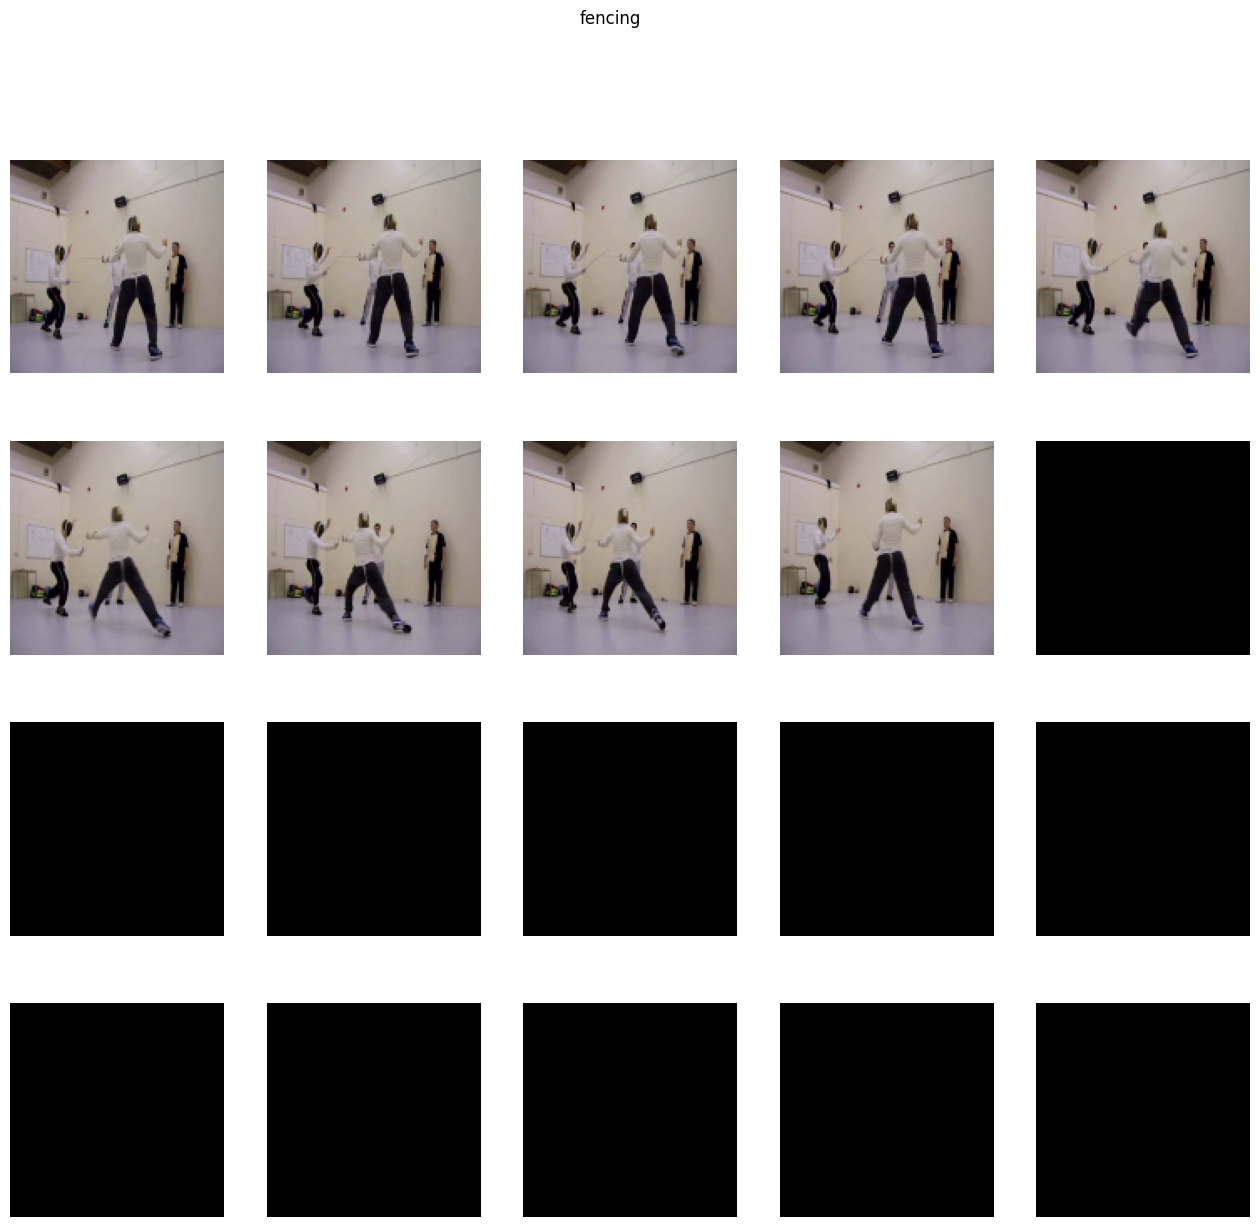

In [129]:
id = np.random.randint(5215)
vid_path = video_paths_train[id]
# pad frames
frames = extract_frames(vid_path, skip=5)
max_frames = 20
padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
num_frames = min(len(frames), max_frames)
padded_frames[:num_frames] = frames[:num_frames]

fig, ax = plt.subplots(4,5, figsize=(16,14))
_ = plt.suptitle(all_classes_names[labels_train[id]])
for i, frame in enumerate(padded_frames):
    frame
    row = i // 5
    col = i % 5
    ax[row,col].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[row,col].set_axis_off()

In [73]:
# Data Generators 
# Create train and test generators
train_gen = video_frame_generator(video_paths_train, labels_train, batch_size, frames_per_video, image_height, image_width)
test_gen = video_frame_generator(video_paths_test, labels_test, batch_size, frames_per_video, image_height, image_width)

In [17]:
pretrained_image_classifier = keras.models.load_model("/kaggle/input/vgg16_fine_tuned_img_enc/keras/hmdb51_8k_train/1/img_enc.h5")
img_enc = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),  # Ensure input shape matches your image size
    *pretrained_image_classifier.layers[:-1]  # Exclude the final output layer
])
img_enc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,648 (60.16 MB)

 Trainable params: 1,056,960 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [74]:
# encoded generators
frames_per_video = 20
encode_train_set = videos_to_encodings(img_enc, video_paths_train, labels_train)
encode_test_set = videos_to_encodings(img_enc, video_paths_test, labels_test)

In [75]:
X_train, y_train = next(encode_train_set)
X_train.shape

100%|██████████| 5215/5215 [36:40<00:00,  2.37it/s]


(5215, 20, 64)

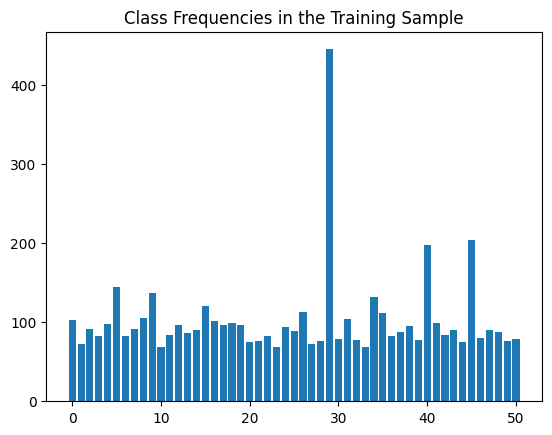

In [138]:
class_counts = np.unique(y_train, return_counts=True)
_ = plt.bar(x=class_counts[0], height=class_counts[1])
_ = plt.title("Class Frequencies in the Training Sample")

In [77]:
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(y_train.shape[0]).batch(50)
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size=0.8, right_size=0.2)

In [78]:
X_test, y_test = next(encode_test_set)

100%|██████████| 1551/1551 [10:55<00:00,  2.36it/s]


In [83]:
img_enc_lstm = keras.Sequential([
    layers.LSTM(128, return_sequences=False, recurrent_dropout=0.1),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_lstm(np.expand_dims(X_train[0], axis=0))

print(img_enc_lstm.summary())
# compile
img_enc_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train
train_hist = img_enc_lstm.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)]
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (1, 128)               │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (1, 256)               │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (1, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (1, 51)                │        13,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,739 (823.20 KB)

 Trainable params: 210,739 (823.20 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.0749 - loss: 3.7540 - val_accuracy: 0.1889 - val_loss: 3.0795 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1808 - loss: 3.0204 - val_accuracy: 0.3106 - val_loss: 2.4676 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2917 - loss: 2.5548 - val_accuracy: 0.4084 - val_loss: 2.0962 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3673 - loss: 2.2581 - val_accuracy: 0.4477 - val_loss: 1.9197 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4067 - loss: 2.0755 - val_accuracy: 0.4947 - val_loss: 1.7365 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4497 - loss: 1.8909 - val_accuracy: 0.5005 - val_loss: 1.6607 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4936 - loss: 1.73

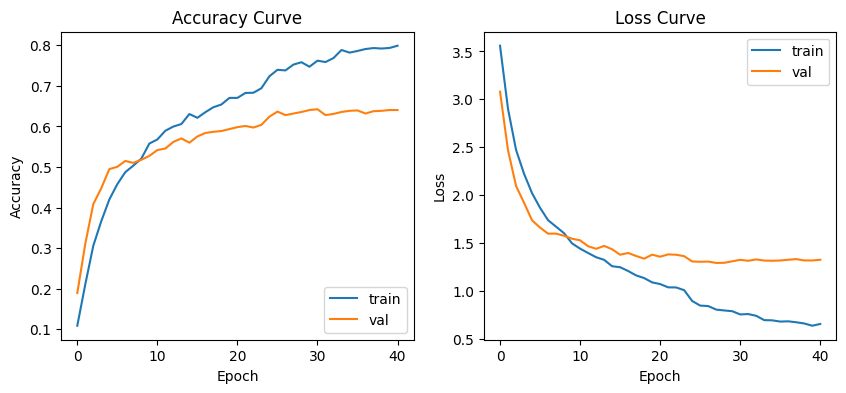

In [86]:
history_frame = pd.DataFrame(train_hist.history)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history_frame.index, history_frame['accuracy'], label='train')
ax[0].plot(history_frame.index, history_frame['val_accuracy'], label='val')
_ = ax[0].set_xlabel('Epoch')
_ = ax[0].set_ylabel('Accuracy')
_ = ax[0].legend(loc='lower right')
_ = ax[0].set_title("Accuracy Curve")

ax[1].plot(history_frame.index, history_frame['loss'], label='train')
ax[1].plot(history_frame.index, history_frame['val_loss'], label='val')
_ = ax[1].set_xlabel('Epoch')
_ = ax[1].set_ylabel('Loss')
_ = ax[1].legend(loc='upper right')
_ = ax[1].set_title("Loss Curve")

In [106]:
# Evaluate the model
train_evaluation = img_enc_lstm.evaluate(X_train, y_train)
print(f"Train Loss: {train_evaluation[0]}, Train Accuracy: {train_evaluation[1]}")
test_evaluation = img_enc_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_evaluation[0]}, Test Accuracy: {test_evaluation[1]}")
print(f"Averaged Accuracy over all 3 splits: {np.mean([test_evaluation[1],train_evaluation[1]])}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8105 - loss: 0.6632
Train Loss: 0.7280383706092834, Train Accuracy: 0.7875359654426575
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7206 - loss: 1.2109
Test Loss: 1.31667160987854, Test Accuracy: 0.6898775100708008
Averaged Accuracy over all 3 splits: 0.7387067377567291


In [99]:
# save training data for reuse:
data = X_train
# Reshape the data: (5212 samples, 20 sequence rows, 64 features)
num_samples, num_sequences, num_features = data.shape
reshaped_data = data.reshape(-1, num_features)  # Shape: (5212 * 20, 64)

# Create MultiIndex: Sample and Sequence Row
sample_index = np.repeat(np.arange(num_samples), num_sequences)  # [0,0,0,...,1,1,1,...]
sequence_index = np.tile(np.arange(num_sequences), num_samples)  # [0,1,2,...,0,1,2,...]

# Combine into a MultiIndex
multi_index = pd.MultiIndex.from_arrays([sample_index, sequence_index], names=["sample", "sequence_row"])

# Create the DataFrame
df = pd.DataFrame(reshaped_data, index=multi_index, columns=[f"feature_{i}" for i in range(num_features)])
df["class"] = [label for label in y_train for i in range(20)]
df["class_name"] = [all_classes_names[label] for label in y_train for i in range(20)]

df.to_csv("encoded_videos_20_frames_subsample_every_5th.csv")


### RCNN with Bi-LSTM

In [111]:
img_enc_bilstm = keras.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=False, recurrent_dropout=0.1)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_bilstm(np.expand_dims(X_train[0], axis=0))

print(img_enc_bilstm.summary())
# compile
img_enc_bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train
train_hist = img_enc_bilstm.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)]
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (1, 256)               │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (1, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (1, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (1, 51)                │        13,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,323 (1.31 MB)

 Trainable params: 342,323 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.0825 - loss: 3.7158 - val_accuracy: 0.3001 - val_loss: 2.7206 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2510 - loss: 2.7273 - val_accuracy: 0.4027 - val_loss: 2.1491 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3431 - loss: 2.2894 - val_accuracy: 0.4132 - val_loss: 2.0199 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4042 - loss: 2.1005 - val_accuracy: 0.4640 - val_loss: 1.8192 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4527 - loss: 1.8819 - val_accuracy: 0.5053 - val_loss: 1.6893 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4953 - loss: 1.7410 - val_accuracy: 0.5235 - val_loss: 1.5878 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5134 - loss: 1.65

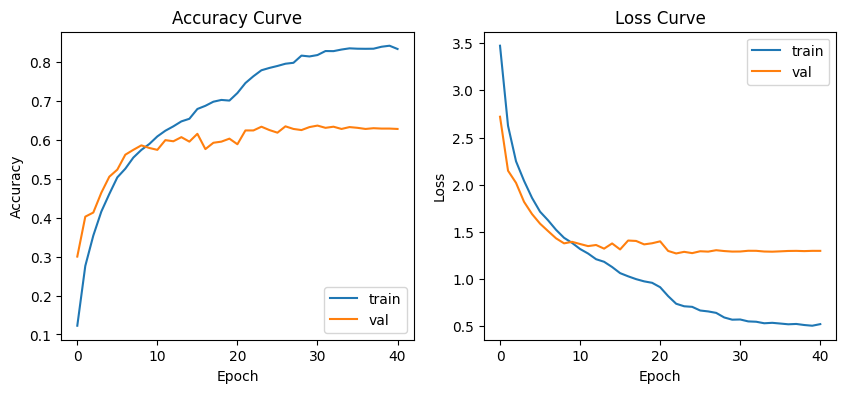

In [113]:
history_frame = pd.DataFrame(train_hist.history)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history_frame.index, history_frame['accuracy'], label='train')
ax[0].plot(history_frame.index, history_frame['val_accuracy'], label='val')
_ = ax[0].set_xlabel('Epoch')
_ = ax[0].set_ylabel('Accuracy')
_ = ax[0].legend(loc='lower right')
_ = ax[0].set_title("Accuracy Curve")

ax[1].plot(history_frame.index, history_frame['loss'], label='train')
ax[1].plot(history_frame.index, history_frame['val_loss'], label='val')
_ = ax[1].set_xlabel('Epoch')
_ = ax[1].set_ylabel('Loss')
_ = ax[1].legend(loc='upper right')
_ = ax[1].set_title("Loss Curve")

In [112]:
# Evaluate the model
train_evaluation = img_enc_bilstm.evaluate(X_train, y_train)
print(f"Train Loss: {train_evaluation[0]}, Train Accuracy: {train_evaluation[1]}")
test_evaluation = img_enc_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_evaluation[0]}, Test Accuracy: {test_evaluation[1]}")
print(f"Averaged Accuracy over all 3 splits: {np.mean([test_evaluation[1],train_evaluation[1]])}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8469 - loss: 0.5277
Train Loss: 0.568613588809967, Train Accuracy: 0.837200403213501
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7384 - loss: 1.1890
Test Loss: 1.343662977218628, Test Accuracy: 0.7027723789215088
Averaged Accuracy over all 3 splits: 0.7699863910675049
